In [1]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
results_dir = './FindSCs'

results = {}
for file in os.listdir(results_dir):
    with open('{}/{}'.format(results_dir, file)) as f:
        data = json.load(f)
        results[file.split('.')[0]] = data

In [3]:
def get_sc_strength(data):
    return data['s_given_m'] - data['s_given_not_m']

def get_cf_score(data):
    return data['cf_score']

def get_d_gap(data):
    return data['both'] - data['just_main']

def get_h_gap(data):
    return data['just_spurious'] - data['neither']

def run(results, score_min = 0, gap_min = 0, verbose = False, save = False):
    names = []
    strengths = []
    scores = []
    d_gaps = []
    h_gaps = []
    
    out = {}
    
    for name in results:
        data = results[name]
        
        strength = get_sc_strength(data)
        score = get_cf_score(data)
        d_gap = get_d_gap(data)
        h_gap = get_h_gap(data)
        
        if score != -1 and d_gap != -1 and h_gap != 1:
            if score >= score_min and (np.abs(d_gap) > gap_min or np.abs(h_gap) > gap_min):
                names.append(name)
                strengths.append(strength)
                scores.append(score)
                d_gaps.append(d_gap)
                h_gaps.append(h_gap)
                
                if verbose:
                    print(name, strength, score, d_gap, h_gap)
                    out[name] = data
    
    if save:
        with open('FindSCs.json', 'w') as f:
            json.dump(out, f)
            
    plt.scatter(scores, strengths)
    plt.ylabel('SC Strength')
    plt.xlabel('CF Score')
    plt.show()
    plt.close()
    
    plt.scatter(scores, d_gaps)
    plt.ylabel('Detection Gap')
    plt.xlabel('CF Score')
    plt.show()
    plt.close()

    plt.scatter(scores, h_gaps)
    plt.ylabel('Hallucination Gap')
    plt.xlabel('CF Score')
    plt.show()
    plt.close()

    plt.scatter(strengths, d_gaps)
    plt.ylabel('Detection Gap')
    plt.xlabel('SC Strength')
    plt.show()
    plt.close()

    plt.scatter(strengths, h_gaps)
    plt.ylabel('Hallucination Gap')
    plt.xlabel('SC Strength')
    plt.show()
    plt.close()

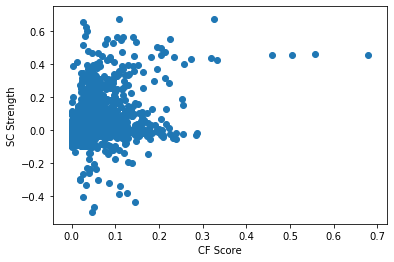

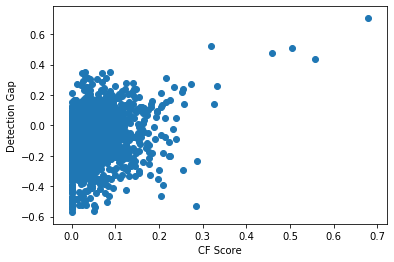

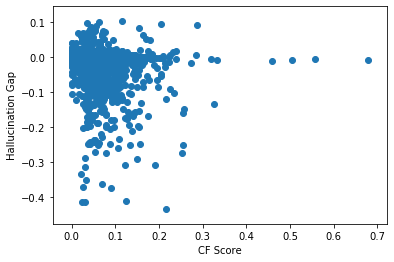

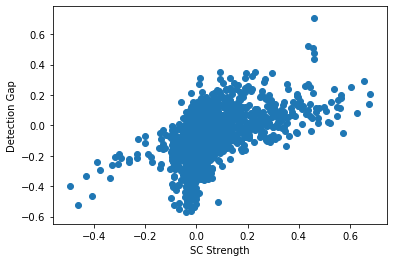

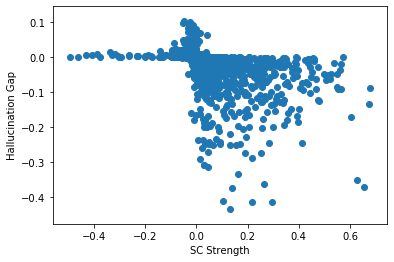

In [4]:
run(results)

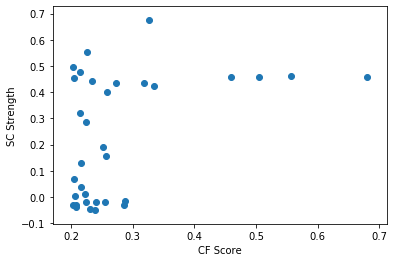

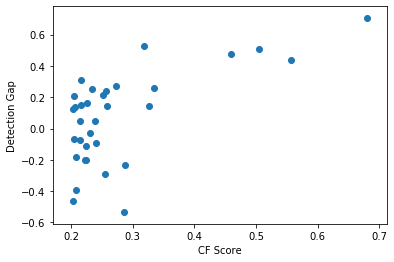

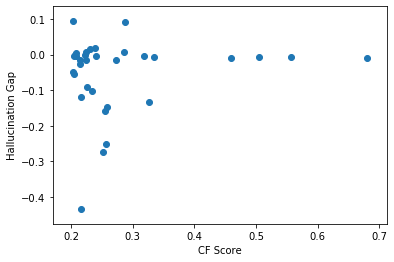

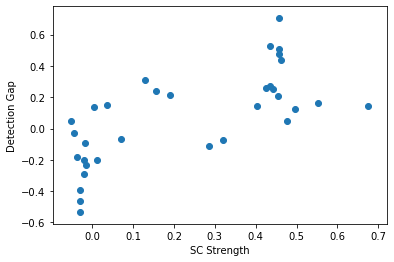

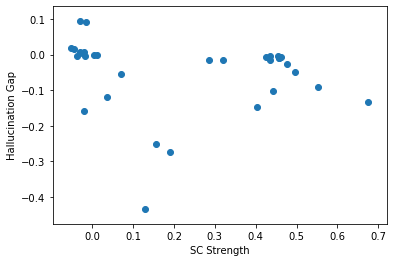

In [5]:
run(results, score_min = 0.2)

toilet-cat 0.011999999999999997 0.2222222222222222 -0.20430555555555563 -2.9695330887258287e-05
surfboard-person 0.43599999999999994 0.31857355126300146 0.5250254810703278 -0.005101958803882312
cake-dining+table 0.497 0.20350877192982456 0.12185401776045049 -0.048379368310291215
dining+table-pizza 0.12999999999999998 0.21558289396602226 0.3105057798704712 -0.4332961820696939
knife-person 0.0040000000000000036 0.2059322033898305 0.13596177388485609 -0.0013605868889701167
tennis+racket-person 0.46099999999999997 0.5572746206486164 0.4362428209497534 -0.0061663996369534235
fork-dining+table 0.676 0.32626488095238093 0.14226756879222274 -0.1328647669059203
chair-bed 0.037000000000000005 0.21628189550425272 0.1527519265839765 -0.12047300326153954
skateboard-person 0.45399999999999996 0.20515071700321919 0.21012584138132864 -0.002902478714963519
cat-umbrella -0.020000000000000004 0.22413793103448276 -0.20125994694960214 0.006499002280829003
person-bear -0.015 0.2875 -0.23326110720699622 0.09

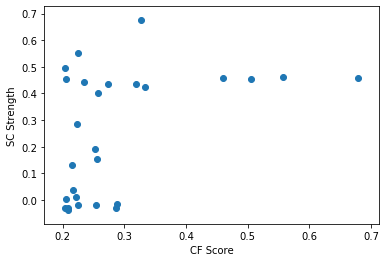

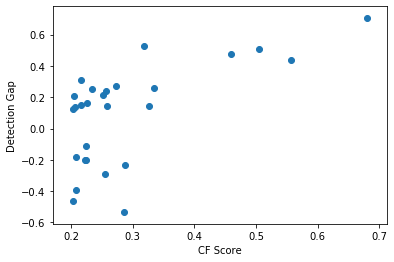

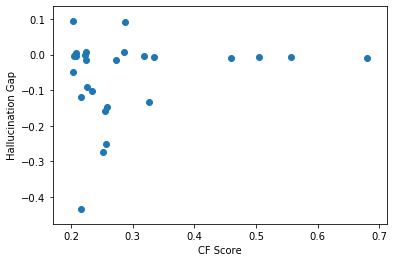

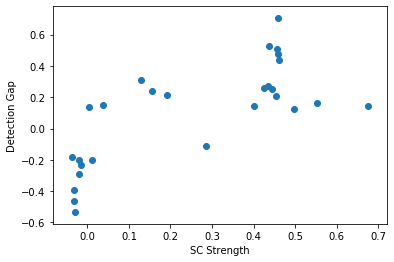

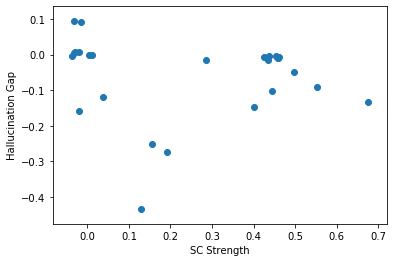

In [6]:
run(results, score_min = 0.2, gap_min = 0.1, verbose = True, save = True)